In [1]:
import pandas as pd 
import seaborn as sns 
import numpy as np 
import matplotlib.pyplot as plt
import mysql.connector

In [2]:
def make_connection_with_db():
    connection = mysql.connector.connect(
    host="localhost",
    user="root",
    password="",
    database="wp_ecommerce")
    cursor = connection.cursor(dictionary=True)
    return connection,cursor 

In [3]:
def get_product_categories(product_id): 

    connection,cursor = make_connection_with_db()
    trem_ids = [] 
    try:
        connection, cursor = make_connection_with_db()

        # Check if connection was successful
        if connection is None or cursor is None:
            print("Database connection failed.")
            return product_name

        sql = """ 
        SELECT wp_term_relationships.object_id ,wp_term_taxonomy.term_id 
        FROM `wp_term_relationships` 
        JOIN wp_term_taxonomy on wp_term_taxonomy.term_taxonomy_id = wp_term_relationships.term_taxonomy_id 
        WHERE wp_term_taxonomy.taxonomy='product_cat' and wp_term_relationships.object_id=(%s)
        ORDER BY `wp_term_taxonomy`.`term_id` ASC
    """

        # Pass parameters as a tuple. mysql.connector handles the escaping.
        cursor.execute(sql, (product_id,))
        results = cursor.fetchall()
        
        if results: # Check if the list is not empty
           trem_ids = [row['term_id'] for row in results ]

    except mysql.connector.Error as err:
        print(f"Database error: {err}. Could not retrieve product name for ID: {product_id}")
        # Optionally log the error details
    except Exception as e:
        print(f"An unexpected error occurred: {e}. Could not retrieve product name for ID: {product_id}")
        # Optionally log the error details
    finally:
        # Ensure cursor and connection are closed in all cases
        if cursor:
            cursor.close()
        if connection:
            connection.close()
    return trem_ids     

In [4]:
get_product_categories(56355)

[79]

In [5]:
def get_category_by_id(category_id): 
    connection,cursor = None,None
    category_name = "Not Found"
    try:
        connection, cursor = make_connection_with_db()

        # Check if connection was successful
        if connection is None or cursor is None:
            print("Database connection failed.")
            return product_name

        sql = """ 
       SELECT name 
       FROM `wp_terms` 
       JOIN wp_term_taxonomy on wp_term_taxonomy.term_id = wp_terms.term_id
       WHERE wp_term_taxonomy.taxonomy='product_cat' and wp_terms.term_id =(%s)
    """

        # Pass parameters as a tuple. mysql.connector handles the escaping.
        cursor.execute(sql, (category_id,))
        results = cursor.fetchall()
        
        if results: # Check if the list is not empty
           category_name = results[0]['name']

    except mysql.connector.Error as err:
        print(f"Database error: {err}. Could not retrieve product name for ID: {product_id}")
        # Optionally log the error details
    except Exception as e:
        print(f"An unexpected error occurred: {e}. Could not retrieve product name for ID: {product_id}")
        # Optionally log the error details
    finally:
        # Ensure cursor and connection are closed in all cases
        if cursor:
            cursor.close()
        if connection:
            connection.close()
    return category_name 


    

In [6]:
get_category_by_id(75)

'ملابس نسائي'

In [7]:
import pandas as pd
import mysql.connector
from typing import Optional, Tuple

def build_customer_data() -> pd.DataFrame:
    """
    Builds a DataFrame containing customer demographic and product category data.
    """
    connection, cursor = None, None
    rows = []  # Use list for faster appending

    try:
        connection, cursor = make_connection_with_db()
        if not connection or not cursor:
            print("❌ Database connection failed.")
            return pd.DataFrame()

        # Get distinct user IDs
        cursor.execute("SELECT DISTINCT user_id FROM wp_usermeta ORDER BY user_id;")
        user_id_results = cursor.fetchall()

        for user_row in user_id_results:
            user_id = user_row['user_id']
            user_obj = {
                'user_id': user_id,
                'customer_id': None,
                'country': None,
                'age': None,
                'gender': None,
                'term_id': None,
                'term_name': "",
                'count_term_id': 0
            }

            # Get demographics
            cursor.execute("""
                SELECT meta_key, meta_value 
                FROM wp_usermeta 
                WHERE user_id = %s AND meta_key IN ('country', 'gender', 'age');
            """, (user_id,))
            for info in cursor.fetchall():
                key = info['meta_key']
                val = info['meta_value']
                if key in user_obj:
                    user_obj[key] = val

            # Get customer_id
            cursor.execute("""
                SELECT customer_id 
                FROM wp_wc_customer_lookup 
                WHERE user_id = %s;
            """, (user_id,))
            customer_info = cursor.fetchone()
            if customer_info:
                user_obj['customer_id'] = customer_info['customer_id']

            # Get product categories
            if user_obj['customer_id'] is not None:
                cursor.execute("""
                    SELECT 
                        wt.term_id,
                        wt.name AS term_name, 
                        COUNT(wt.term_id) AS count_term_id 
                    FROM 
                        wp_wc_order_product_lookup wwopl 
                    JOIN 
                        wp_term_relationships wtr ON wwopl.product_id = wtr.object_id
                    JOIN 
                        wp_term_taxonomy wtt ON wtr.term_taxonomy_id = wtt.term_taxonomy_id 
                    JOIN 
                        wp_terms wt ON wtt.term_id = wt.term_id 
                    JOIN 
                        wp_posts wp ON wwopl.order_id = wp.ID 
                    JOIN 
                        wp_postmeta wpm ON wp.ID = wpm.post_id 
                    WHERE 
                        wtt.taxonomy = 'product_cat' 
                        AND wpm.meta_key = '_customer_user' 
                        AND wpm.meta_value = %s 
                    GROUP BY 
                        wt.term_id, wt.name, wtt.taxonomy 
                    ORDER BY 
                        count_term_id DESC;
                """, (user_obj['customer_id'],))
                terms_info = cursor.fetchall()

                if terms_info:
                    for term_row in terms_info:
                        row = user_obj.copy()
                        row.update({
                            'term_id': term_row['term_id'],
                            'term_name': term_row['term_name'],
                            'count_term_id': term_row['count_term_id']
                        })
                        rows.append(row)
                else:
                    rows.append(user_obj)
            else:
                rows.append(user_obj)

    except mysql.connector.Error as err:
        print(f"❌ Database error: {err}")
    except Exception as e:
        print(f"❌ Unexpected error: {e}")
    finally:
        if cursor: cursor.close()
        if connection: connection.close()

    return pd.DataFrame(rows)


In [8]:
# Example usage (uncomment and replace placeholder credentials in make_connection_with_db to run)
# customer_df = build_customer_data()
# print("--- Customer Data Head ---")
# print(customer_df.head())
# print("\n--- Customer Data Info ---")
# print(customer_df.info())

In [9]:
# df.info()

In [27]:
def build_customer_data_v2():
    """
    Builds a DataFrame containing customer demographic data and their most purchased product category.
    The function is optimized for performance by querying and processing data in bulk.
    """

    import pandas as pd
    import mysql.connector
    from collections import defaultdict

    connection, cursor = None, None

    try:
        # Establish connection with the database
        connection, cursor = make_connection_with_db()
        if not connection or not cursor:
            print("❌ Failed to connect to the database.")
            return pd.DataFrame()

        # =====================
        # Step 1: Fetch user demographics (country, gender, age)
        # =====================
        cursor.execute("""
            SELECT user_id, meta_key, meta_value
            FROM wp_usermeta
            WHERE meta_key IN ('country', 'gender', 'age');
        """)
        user_meta_rows = cursor.fetchall()

        # Build a dictionary: demographics[user_id][meta_key] = meta_value
        demographics = defaultdict(dict)
        for row in user_meta_rows:
            demographics[row['user_id']][row['meta_key']] = row['meta_value']

        # =====================
        # Step 2: Map user_id to customer_id from wp_wc_customer_lookup
        # =====================
        cursor.execute("SELECT user_id, customer_id FROM wp_wc_customer_lookup;")
        customer_rows = cursor.fetchall()

        user_to_customer = {row['user_id']: row['customer_id'] for row in customer_rows}
        customer_to_user = {row['customer_id']: row['user_id'] for row in customer_rows}  # Not used but good for reference

        # =====================
        # Step 3: Fetch product category purchase counts per customer
        # =====================
        cursor.execute("""
            SELECT 
                wccl.user_id,             -- Link user_id from customer lookup
                wccl.customer_id,         -- customer_id to match product lookup
                wt.term_id,
                wt.name AS term_name,
                COUNT(wt.term_id) AS count_term_id
            FROM wp_wc_order_product_lookup wwopl
            JOIN wp_posts wp ON wwopl.order_id = wp.ID
            JOIN wp_postmeta wpm ON wp.ID = wpm.post_id
            JOIN wp_wc_customer_lookup wccl ON wpm.meta_value = wccl.user_id AND wpm.meta_key = '_customer_user'
            JOIN wp_term_relationships wtr ON wwopl.product_id = wtr.object_id
            JOIN wp_term_taxonomy wtt ON wtr.term_taxonomy_id = wtt.term_taxonomy_id
            JOIN wp_terms wt ON wtt.term_id = wt.term_id
            WHERE wtt.taxonomy = 'product_cat'
            GROUP BY wccl.user_id, wccl.customer_id, wt.term_id, wt.name
            ORDER BY wccl.customer_id, count_term_id DESC;
        """)
        term_rows = cursor.fetchall()

        # =====================
        # Step 4: Get only the top category per user (most purchased)
        # =====================
        user_top_category = {}
        for row in term_rows:
            user_id = int(row['user_id'])
            customer_id = int(row['customer_id'])

            # Store the category with highest count_term_id
            current_top = user_top_category.get(user_id, {})
            if row['count_term_id'] > current_top.get('count_term_id', -1):
                user_top_category[user_id] = {
                    'customer_id': customer_id,
                    'term_id': row['term_id'],
                    'term_name': row['term_name'],
                    'count_term_id': row['count_term_id']
                }

        # =====================
        # Step 5: Combine all data per user into final format
        # =====================
        all_user_ids = set(demographics.keys()) | set(user_to_customer.keys()) | set(user_top_category.keys())
        final_data = []

        for user_id in sorted(all_user_ids):
            user_obj = {
                'user_id': user_id,
                'customer_id': user_to_customer.get(user_id),
                'country': demographics.get(user_id, {}).get('country'),
                'age': demographics.get(user_id, {}).get('age'),
                'gender': demographics.get(user_id, {}).get('gender'),
                'term_id': None,
                'term_name': "",
                'count_term_id': 0
            }

            # Overwrite with top category info if available
            if user_id in user_top_category:
                top = user_top_category[user_id]
                if top.get('customer_id') is not None:
                    user_obj['customer_id'] = top['customer_id']
                user_obj['term_id'] = top['term_id']
                user_obj['term_name'] = top['term_name']
                user_obj['count_term_id'] = top['count_term_id']

            final_data.append(user_obj)

        # =====================
        # Step 6: Convert to DataFrame with proper data types
        # =====================
        df = pd.DataFrame(final_data)
        df['customer_id'] = pd.to_numeric(df['customer_id'], errors='coerce').astype('Int64')
        df['age'] = pd.to_numeric(df['age'], errors='coerce').astype('Int64')
        df['term_id'] = pd.to_numeric(df['term_id'], errors='coerce').astype('Int64')
        df['count_term_id'] = pd.to_numeric(df['count_term_id'], errors='coerce').astype('Int64')

        return df

    except mysql.connector.Error as err:
        print(f"❌ Database error: {err}")
        return pd.DataFrame()
    except Exception as e:
        print(f"❌ Unexpected error: {e}")
        return pd.DataFrame()
    finally:
        if cursor:
            cursor.close()
        if connection:
            connection.close()


In [45]:
customer_df = build_customer_data_v2()
print("--- Customer Data Head ---")
customer_df


--- Customer Data Head ---


,user_id,customer_id,country,age,gender,term_id,term_name,count_term_id
0,1,294,SA,36,انثى,75,ملابس نسائي,4
1,2,736,JO,48,انثى,75,ملابس نسائي,4
2,3,435,KW,40,ذكر,78,إلكترونيات,8
3,4,961,AE,24,ذكر,<NA>,,0
4,5,86,JO,35,انثى,75,ملابس نسائي,4
...,...,...,...,...,...,...,...,...
1497,1498,<NA>,SA,49,انثى,<NA>,,0
1498,1499,<NA>,SA,25,انثى,<NA>,,0
1499,1500,<NA>,SA,22,انثى,<NA>,,0
1500,1501,<NA>,JO,33,ذكر,<NA>,,0


In [46]:
print("\n--- Customer Data Info ---")
customer_df.info()


--- Customer Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1502 entries, 0 to 1501
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   user_id        1502 non-null   int64 
 1   customer_id    981 non-null    Int64 
 2   country        1502 non-null   object
 3   age            1502 non-null   Int64 
 4   gender         1502 non-null   object
 5   term_id        977 non-null    Int64 
 6   term_name      1502 non-null   object
 7   count_term_id  1502 non-null   Int64 
dtypes: Int64(4), int64(1), object(3)
memory usage: 99.9+ KB


In [47]:
customer_df.isnull().sum()

user_id            0
customer_id      521
country            0
age                0
gender             0
term_id          525
term_name          0
count_term_id      0
dtype: int64

In [48]:
customer_df=customer_df.dropna()


In [49]:
customer_df.duplicated().sum()

0

In [50]:
customer_df.describe()


,user_id,customer_id,age,term_id,count_term_id
count,977.000000,977.0,977.0,977.0,977.0
mean,501.622313,489.134084,36.598772,75.88741,5.62436
std,288.538207,282.40481,10.983348,1.847577,3.282957
min,1.000000,1.0,18.0,74.0,1.0
25%,252.000000,245.0,27.0,74.0,3.0
50%,501.000000,489.0,37.0,75.0,5.0
75%,752.000000,733.0,46.0,78.0,7.0
max,999.000000,981.0,55.0,82.0,20.0


In [53]:
customer_df

,user_id,customer_id,country,age,gender,term_id,term_name,count_term_id
0,1,294,4,36,0,75,ملابس نسائي,4
1,2,736,2,48,0,75,ملابس نسائي,4
2,3,435,3,40,1,78,إلكترونيات,8
4,5,86,2,35,0,75,ملابس نسائي,4
5,6,245,1,29,1,74,ملابس رجالي,9
...,...,...,...,...,...,...,...,...
994,995,715,3,44,0,75,ملابس نسائي,3
995,996,467,0,26,0,75,ملابس نسائي,4
996,997,426,1,54,0,75,ملابس نسائي,6
997,998,664,2,43,1,78,إلكترونيات,7


In [52]:
from sklearn.preprocessing import LabelEncoder 

country_le = LabelEncoder() 
gender_le = LabelEncoder() 

customer_df.loc[:, 'country'] = country_le.fit_transform(customer_df['country'])
customer_df.loc[:, 'gender'] = gender_le.fit_transform(customer_df['gender'])

<Figure size 1000x700 with 0 Axes>

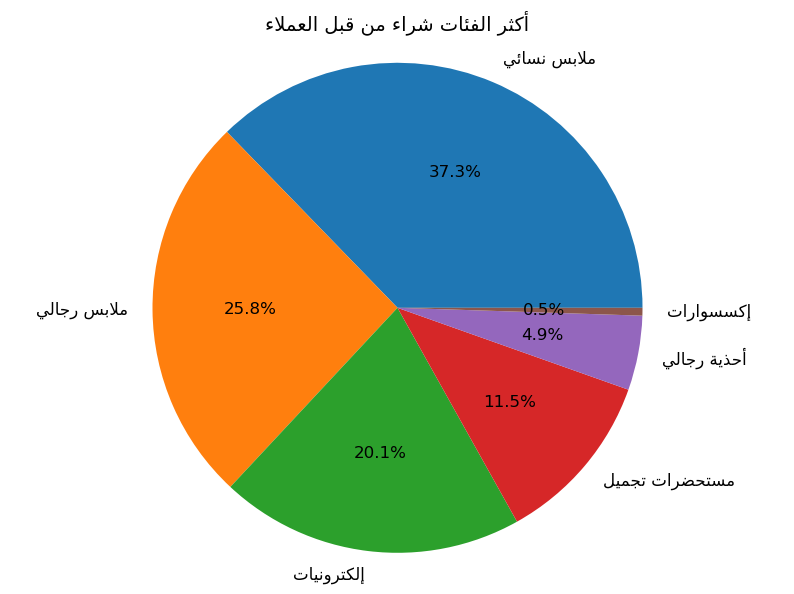

In [57]:
plt.figure(figsize=(10,7))
import arabic_reshaper 
from bidi.algorithm import get_display 

# Prepare the data
x = customer_df['term_name'].value_counts()

# Reshape and fix direction of Arabic labels
reshaped_labels = [get_display(arabic_reshaper.reshape(label)) for label in x.index]

# Plotting the pie chart
plt.figure(figsize=(10, 7))
plt.pie(x, labels=reshaped_labels, autopct='%1.1f%%', textprops={'fontsize': 12})
plt.title(get_display(arabic_reshaper.reshape('أكثر الفئات شراءً من قبل العملاء')), fontsize=14)
plt.axis('equal')
plt.show()


In [87]:
X = customer_df[['country','age','gender']]
y = customer_df['term_id']

In [88]:
from collections import Counter 
n = customer_df.iloc[:,-2].count()
c = Counter(y)
for k,v in c.items() : 
    per = (v/n)*100
    print(f'Class {k} >  n = {v} > rate= {per}')

Class 75 >  n = 364 > rate= 37.25690890481064
Class 78 >  n = 196 > rate= 20.061412487205732
Class 74 >  n = 252 > rate= 25.79324462640737
Class 79 >  n = 112 > rate= 11.463664278403275
Class 82 >  n = 5 > rate= 0.511770726714432
Class 76 >  n = 48 > rate= 4.912998976458546


In [89]:
# !pip install imbalanced-learn

In [90]:
from imblearn.over_sampling import RandomOverSampler 

oversample = RandomOverSampler(random_state=42) # It's good practice to set a random_state for reproducibility
X,y = oversample.fit_resample(X,y)

In [93]:
from collections import Counter 
n = customer_df.iloc[:,-2].count()
c = Counter(y)
n = X.iloc[:,0].count()
for k,v in c.items() : 
    per = (v/n)*100
    print(f'Class {k} >  n = {v} > rate= {per}')

Class 75 >  n = 364 > rate= 16.666666666666664
Class 78 >  n = 364 > rate= 16.666666666666664
Class 74 >  n = 364 > rate= 16.666666666666664
Class 79 >  n = 364 > rate= 16.666666666666664
Class 82 >  n = 364 > rate= 16.666666666666664
Class 76 >  n = 364 > rate= 16.666666666666664


In [95]:
from sklearn.model_selection import cross_val_score 
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import CategoricalNB
from sklearn.neighbors import KNeighborsClassifier

model_decision_tree = DecisionTreeClassifier() 
model_naive_bayes = CategoricalNB() 
model_k_n_n = KNeighborsClassifier()

scores_accuracy = cross_val_score(model_decision_tree,X,y,cv=10,scoring='accuracy')
mean_score = scores_accuracy.mean() 
print(f"Descision Tree Accuracy {round(mean_score,2)*100}")

scores_accuracy = cross_val_score(model_naive_bayes,X,y,cv=10,scoring='accuracy')
mean_score = scores_accuracy.mean() 
print(f"Navie Bayes Accuracy  {round(mean_score,2)*100}")

scores_accuracy = cross_val_score(model_k_n_n,X,y,cv=10,scoring='accuracy')
mean_score = scores_accuracy.mean() 
print(f"KNN Accuracy  {round(mean_score,2)*100}")



Descision Tree Accuracy 80.0
Navie Bayes Accuracy  69.0
KNN Accuracy  66.0


In [96]:
model = DecisionTreeClassifier()
model.fit(X,y)

DecisionTreeClassifier()

In [128]:
input_df = pd.DataFrame([{
        'country': 2,
        'age': 45,
        'gender': 1
    }])
pred_y = model.predict(input_df)
pred_y

array([76.])

In [129]:
pred_y

array([76.])

In [130]:


pred_y_p= model.predict_proba(input_df)
pred_y_p


array([[0.14285714, 0.        , 0.42857143, 0.42857143, 0.        ,
        0.        ]])

In [131]:
import pickle 


filename = 'classification_model'
pickle.dump(model,open(filename,'wb'))

In [132]:
loaded_model = pickle.load(open(filename,'rb'))
res = loaded_model.predict(input_df)
print(res)

[76.]


In [133]:
def get_category_code(filename,country,age,gender): 
    import pickle 
    loaded_model = pickle.load(open(filename,'rb'))
    # Create a DataFrame with correct feature names
    input_df = pd.DataFrame([{
        'country': country,
        'age': age,
        'gender': gender
    }])

    # Predict
    res = loaded_model.predict(input_df)
    # print(res)
    return res[0]
    


In [135]:
get_category_by_id(get_category_code(filename,2,40,1))

'ملابس رجالي'

In [137]:
# !pip install m2cgen

In [139]:
import  m2cgen as m2c 
model_to_php = m2c.export_to_php(model)
f= open('predict_category.php','w')
f.write(model_to_php)
f.close()

In [149]:
def label_encoder_to_db(table, col_name, col_type, le):
    """
    Creates a database table and populates it with LabelEncoder mappings.

    Args:
        table (str): The desired name for the database table (e.g., 'custom_country_code').
        col_name (str): The name of the column that will store the original
                        text labels (e.g., 'country_name', 'gender_label').
        col_type (str): The SQL data type for the original label column
                        (e.g., 'VARCHAR(255)', 'CHAR(2)').
        le (LabelEncoder): A **fitted** LabelEncoder object.
    """
    connection, cursor = None, None
    try:
        connection, cursor = make_connection_with_db()

        if connection is None or cursor is None:
            print("❌ Database connection failed. Cannot proceed.")
            return

        # Step 0: Drop the table if it already exists
        drop_sql = f"DROP TABLE IF EXISTS {table};"
        print(f"Attempting to execute: {drop_sql}") # For debugging

        try:
            cursor.execute(drop_sql)
            connection.commit() # Commit the drop operation
            print(f"✅ Table '{table}' dropped successfully (if it existed).")
        except mysql.connector.Error as err:
            # Catch specific errors during the drop operation
            print(f"❌ Error dropping table '{table}': {err}")
            # If dropping fails, we might not want to proceed with creation
            return 

        # Step 1: Create the table
        create_sql = f"""
        CREATE TABLE {table} (
            ID INT AUTO_INCREMENT PRIMARY KEY,
            code INT NOT NULL UNIQUE,
            {col_name} {col_type} NOT NULL
        ) ENGINE=InnoDB DEFAULT CHARSET=utf8mb4;
        """
        print(f"Attempting to execute: {create_sql}") # For debugging
        cursor.execute(create_sql)
        connection.commit()
        print(f"✅ Table '{table}' created successfully.")

        # Step 2: Insert label-encoded values
        insert_sql = f"INSERT INTO {table} (code, {col_name}) VALUES (%s, %s);"
        for original_label in le.classes_:
            code = int(le.transform([original_label])[0])
            cursor.execute(insert_sql, (code, original_label))
        connection.commit() # Commit inserts in a single batch for performance

        print(f"✅ Label mappings inserted into `{table}` successfully.")

    except mysql.connector.Error as err:
        print(f"❌ Database error: {err}")
        # Consider adding a connection.rollback() here if needed for partial transactions

    except Exception as e:
        print(f"❌ An unexpected error occurred: {e}")

    finally:
        if cursor:
            cursor.close()
        if connection:
            connection.close()

In [150]:
label_encoder_to_db('custom_country_code', 'country', 'CHAR(2)', country_le)
label_encoder_to_db('custom_gender_code', 'gender', 'VARCHAR(10)', gender_le)

Attempting to execute: DROP TABLE IF EXISTS custom_country_code;
✅ Table 'custom_country_code' dropped successfully (if it existed).
Attempting to execute: 
        CREATE TABLE custom_country_code (
            ID INT AUTO_INCREMENT PRIMARY KEY,
            code INT NOT NULL UNIQUE,
            country CHAR(2) NOT NULL
        ) ENGINE=InnoDB DEFAULT CHARSET=utf8mb4;
        
✅ Table 'custom_country_code' created successfully.
✅ Label mappings inserted into `custom_country_code` successfully.
Attempting to execute: DROP TABLE IF EXISTS custom_gender_code;
✅ Table 'custom_gender_code' dropped successfully (if it existed).
Attempting to execute: 
        CREATE TABLE custom_gender_code (
            ID INT AUTO_INCREMENT PRIMARY KEY,
            code INT NOT NULL UNIQUE,
            gender VARCHAR(10) NOT NULL
        ) ENGINE=InnoDB DEFAULT CHARSET=utf8mb4;
        
✅ Table 'custom_gender_code' created successfully.
✅ Label mappings inserted into `custom_gender_code` successfully.


In [154]:
# pip freeze > requerments.txt

In [246]:
def category_best_seller_produtcts(category_id,n=3): 
    connection, cursor = None, None
    products_ids = "Not Found"
    try:
        connection, cursor = make_connection_with_db()

        if connection is None or cursor is None:
            print("❌ Database connection failed. Cannot proceed.")
            return

        sql = f"""
        SELECT wt.term_id , wwopl.product_id,SUM(wwopl.product_qty) as sumsales 
        FROM wp_wc_order_product_lookup wwopl
        JOIN wp_term_relationships wtr on wtr.object_id = wwopl.product_id 
        JOIN wp_term_taxonomy wtt on wtt.term_taxonomy_id = wtr.term_taxonomy_id 
        JOIN wp_terms wt on wt.term_id =wtt.term_id 
        where wtt.taxonomy = 'product_cat' and wtt.term_id =(%s)
        GROUP By wt.term_id , wwopl.product_id 
        ORDER by sumsales DESC;
        """

        cursor.execute(sql,(category_id,))
        results = cursor.fetchall() 
        if results : 
            products_ids = pd.DataFrame( results[:n] )
            

    
    except mysql.connector.Error as err:
        print(f"❌ Database error: {err}")
        # Consider adding a connection.rollback() here if needed for partial transactions

    except Exception as e:
        print(f"❌ An unexpected error occurred: {e}")

    finally:
        if cursor:
            cursor.close()
        if connection:
            connection.close()
    return products_ids        

In [247]:
best_df = category_best_seller_produtcts(78)

In [248]:
def get_product_name_from_id(product_id):
    product_name = 'Not Found' # Initialize with default

    try:
        connection, cursor = make_connection_with_db()

        # Check if connection was successful
        if connection is None or cursor is None:
            print("Database connection failed.")
            return product_name

        # Correct SQL query syntax for parameter binding: use %s
        sql = 'SELECT wp_posts.post_title as product_title FROM wp_posts WHERE wp_posts.ID = %s;'

        # Pass parameters as a tuple. mysql.connector handles the escaping.
        cursor.execute(sql, (product_id,))
        results = cursor.fetchall()

        if results: # Check if the list is not empty
            product_name = results[0]['product_title']

    except mysql.connector.Error as err:
        print(f"Database error: {err}. Could not retrieve product name for ID: {product_id}")
        # Optionally log the error details
    except Exception as e:
        print(f"An unexpected error occurred: {e}. Could not retrieve product name for ID: {product_id}")
        # Optionally log the error details
    finally:
        # Ensure cursor and connection are closed in all cases
        if cursor:
            cursor.close()
        if connection:
            connection.close()

    return product_name 

In [249]:
for i in best_df.iloc[:,1]:
    print(get_product_name_from_id(product_id=i))

فرن-أبيض-LG
غسالة-أسود-SAMSUNG
غسالة-أسود-LG


In [250]:
def get_gender_code(gender):
    gender_code = 'Not Found' # Initialize with default
    try:
        connection, cursor = make_connection_with_db()

        # Check if connection was successful
        if connection is None or cursor is None:
            print("Database connection failed.")
            return product_name

        # Correct SQL query syntax for parameter binding: use %s
        sql = 'SELECT *  FROM custom_gender_code cgd WHERE cgd.gender = %s;'
        gender =gender.lower()
        if(gender == 'male'):
            gender = 'ذكر'
        elif (gender == 'female'): 
            gender = 'انثى'
        # print(gender)    
        # Pass parameters as a tuple. mysql.connector handles the escaping.
        cursor.execute(sql, (gender,))
        results = cursor.fetchall()

        if results: # Check if the list is not empty
            gender_code = results[0]['code']

    except mysql.connector.Error as err:
        print(f"Database error: {err}. Could not retrieve gender code of: {gender}")
        # Optionally log the error details
    except Exception as e:
        print(f"An unexpected error occurred: {e}. Could not retrieve gender code of: {gender}")
        # Optionally log the error details
    finally:
        # Ensure cursor and connection are closed in all cases
        if cursor:
            cursor.close()
        if connection:
            connection.close()

    return gender_code

In [251]:
get_gender_code('FemaLe')

0

In [252]:
def get_country_code(country):
    country_code = 'Not Found' # Initialize with default
    try:
        connection, cursor = make_connection_with_db()

        # Check if connection was successful
        if connection is None or cursor is None:
            print("Database connection failed.")
            return product_name

        # Correct SQL query syntax for parameter binding: use %s
        sql = 'SELECT *  FROM custom_country_code cgd WHERE cgd.country = %s;'
        country =country.upper()
      
        # Pass parameters as a tuple. mysql.connector handles the escaping.
        cursor.execute(sql, (country,))
        results = cursor.fetchall()

        if results: # Check if the list is not empty
           country_code = results[0]['code']

    except mysql.connector.Error as err:
        print(f"Database error: {err}. Could not retrieve country code of: {country}")
        # Optionally log the error details
    except Exception as e:
        print(f"An unexpected error occurred: {e}. Could not retrieve country code of: {country}")
        # Optionally log the error details
    finally:
        # Ensure cursor and connection are closed in all cases
        if cursor:
            cursor.close()
        if connection:
            connection.close()

    return country_code

In [253]:
get_country_code('kw')

3

In [257]:
def get_customer_products(customer_id,n=3): 
    country ,age,gender = "",0,""
    products = []
    try:
        connection, cursor = make_connection_with_db()

        # Check if connection was successful
        if connection is None or cursor is None:
            print("Database connection failed.")
            return product_name

        # Correct SQL query syntax for parameter binding: use %s
        sql = 'SELECT user_id,country FROM wp_wc_customer_lookup cgd WHERE cgd.customer_id = %s;'
      
        # Pass parameters as a tuple. mysql.connector handles the escaping.
        cursor.execute(sql, (customer_id,))
        results = cursor.fetchall()

        if results: # Check if the list is not empty
            user_id = results[0]['user_id']
            country = results[0]['country']
            country_code = get_country_code(country)

            age = 0
            gender = 0 
            sql = 'SELECT meta_value FROM  wp_usermeta wum  WHERE wum.user_id = %s and wum.meta_key = "age";'
      
            # Pass parameters as a tuple. mysql.connector handles the escaping.
            cursor.execute(sql, (user_id,))
            res = cursor.fetchall()
            if res : 
                age = res[0]['meta_value']
                
            sql = 'SELECT meta_value FROM  wp_usermeta wum  WHERE wum.user_id = %s and wum.meta_key = "gender";'
      
            # Pass parameters as a tuple. mysql.connector handles the escaping.
            cursor.execute(sql, (user_id,))
            res = cursor.fetchall()
            if res : 
                gender = res[0]['meta_value']
                
            gender_code = get_gender_code(gender)

            category_code = get_category_code('classification_model',country_code,age,gender_code)
            products_df = category_best_seller_produtcts(category_code,n=n)
            for i in products_df.iloc[:,1]:
                products.append(get_product_name_from_id(product_id=i))
    except mysql.connector.Error as err:
        print(f"Database error: {err}.")
        # Optionally log the error details
    except Exception as e:
        print(f"An unexpected error occurred: {e}.")
        # Optionally log the error details
    finally:
        # Ensure cursor and connection are closed in all cases
        if cursor:
            cursor.close()
        if connection:
            connection.close()

    return products 

In [260]:
get_customer_products(1,6)

['فرن-أبيض-LG',
 'غسالة-أسود-SAMSUNG',
 'غسالة-أسود-LG',
 'فرن-بني-HP',
 'فرن-أبيض-PANASONIC',
 'غسالة-أسود داكن-HP']